# Analyse der Daten 

## Analyse der anteile der sprachen in dem gesamten Unpaywall Datensatz

path : /ds-slt/sci-LLM/scilons/unpaywall_texts_pq/unpaywall_texts_pq_3/*

```
ls /ds-slt/sci-LLM/scilons/unpaywall_texts_pq/unpaywall_texts_pq_3/*
```


In [ ]:
# Installation der pakete auf dem server / cluster
!python -m pip install --upgrade pip
!pip install umap-learn hdbscan faiss-gpu numpy sentence-transformers duckdb tqdm seaborn gensim nltk

In [2]:
ls /ds-slt/sci-LLM/scilons/unpaywall_texts_pq/unpaywall_texts_pq_3/

ace_Arab/  deu_Latn/                     kac_Latn/  mos_Latn/  ssw_Latn/
ace_Latn/  dik_Latn/                     kam_Latn/  mri_Latn/  sun_Latn/
acm_Arab/  dyu_Latn/                     kan_Knda/  mya_Mymr/  swe_Latn/
acq_Arab/  dzo_Tibt/                     kas_Arab/  nld_Latn/  swh_Latn/
aeb_Arab/  ell_Grek/                     kas_Deva/  nno_Latn/  szl_Latn/
afr_Latn/  eng_Latn/                     kat_Geor/  nob_Latn/  tam_Taml/
ajp_Arab/  epo_Latn/                     kaz_Cyrl/  npi_Deva/  taq_Latn/
als_Latn/  est_Latn/                     kbp_Latn/  nso_Latn/  taq_Tfng/
amh_Ethi/  eus_Latn/                     kea_Latn/  nus_Latn/  tat_Cyrl/
apc_Arab/  ewe_Latn/                     khk_Cyrl/  nya_Latn/  tel_Telu/
arb_Arab/  fao_Latn/                     khm_Khmr/  oci_Latn/  tgk_Cyrl/
ars_Arab/  fij_Latn/                     kik_Latn/  ory_Orya/  tgl_Latn/
ary_Arab/  fin_Latn/                     kin_Latn/  pag_Latn/  tha_Thai/
arz_Arab/  fon_Latn/                     kir_Cyrl/ 

In [9]:
# look at the log file 
# !cat /ds-slt/sci-LLM/scilons/unpaywall_texts_pq/unpaywall_texts_pq_3/grobid_to_parquet.log

!cat /ds-slt/sci-LLM/scilons/unpaywall_texts_pq/unpaywall_texts_pq_3/grobid_to_parquet_args.json


{"input_dir": "/netscratch/mostendorff/datasets/scilons/unpaywall", "output_dir": "/netscratch/fbarth/dataset/scilons/unpaywall_texts_pq_3", "workers": 24, "max_docs_per_input_file": 0, "max_input_files": 0, "max_rows_per_output_file": 1048576, "max_rows_per_output_file_group": 65536, "langid_model": "resources/models/lid201-model.ftz", "shuffle_input_files": false, "override": false, "debug": false}


Language Distribution Statistics:
Total size across all languages: 414.5 GB

Breakdown by language:
Language    Size_GB  File_Count  Percentage
eng_Latn 306.484679          26   73.949599
por_Latn  25.300513           2    6.104588
spa_Latn  14.549277           1    3.510496
jpn_Jpan  10.713605           2    2.585013
rus_Cyrl   9.046993           1    2.182887
deu_Latn   8.248075           1    1.990122
fra_Latn   7.948504           1    1.917840
ind_Latn   5.159720           1    1.244954
ukr_Cyrl   3.186756           1    0.768911
tur_Latn   2.531374           1    0.610778
pol_Latn   2.457716           1    0.593006
arb_Arab   1.280555           1    0.308976
zho_Hant   0.999345           1    0.241125
hun_Latn   0.932144           1    0.224911
nld_Latn   0.878066           1    0.211862
ita_Latn   0.792011           1    0.191099
kor_Hang   0.783865           1    0.189133
mlt_Latn   0.775410           1    0.187093
dan_Latn   0.664494           1    0.160331
zho_Hans   0.632602

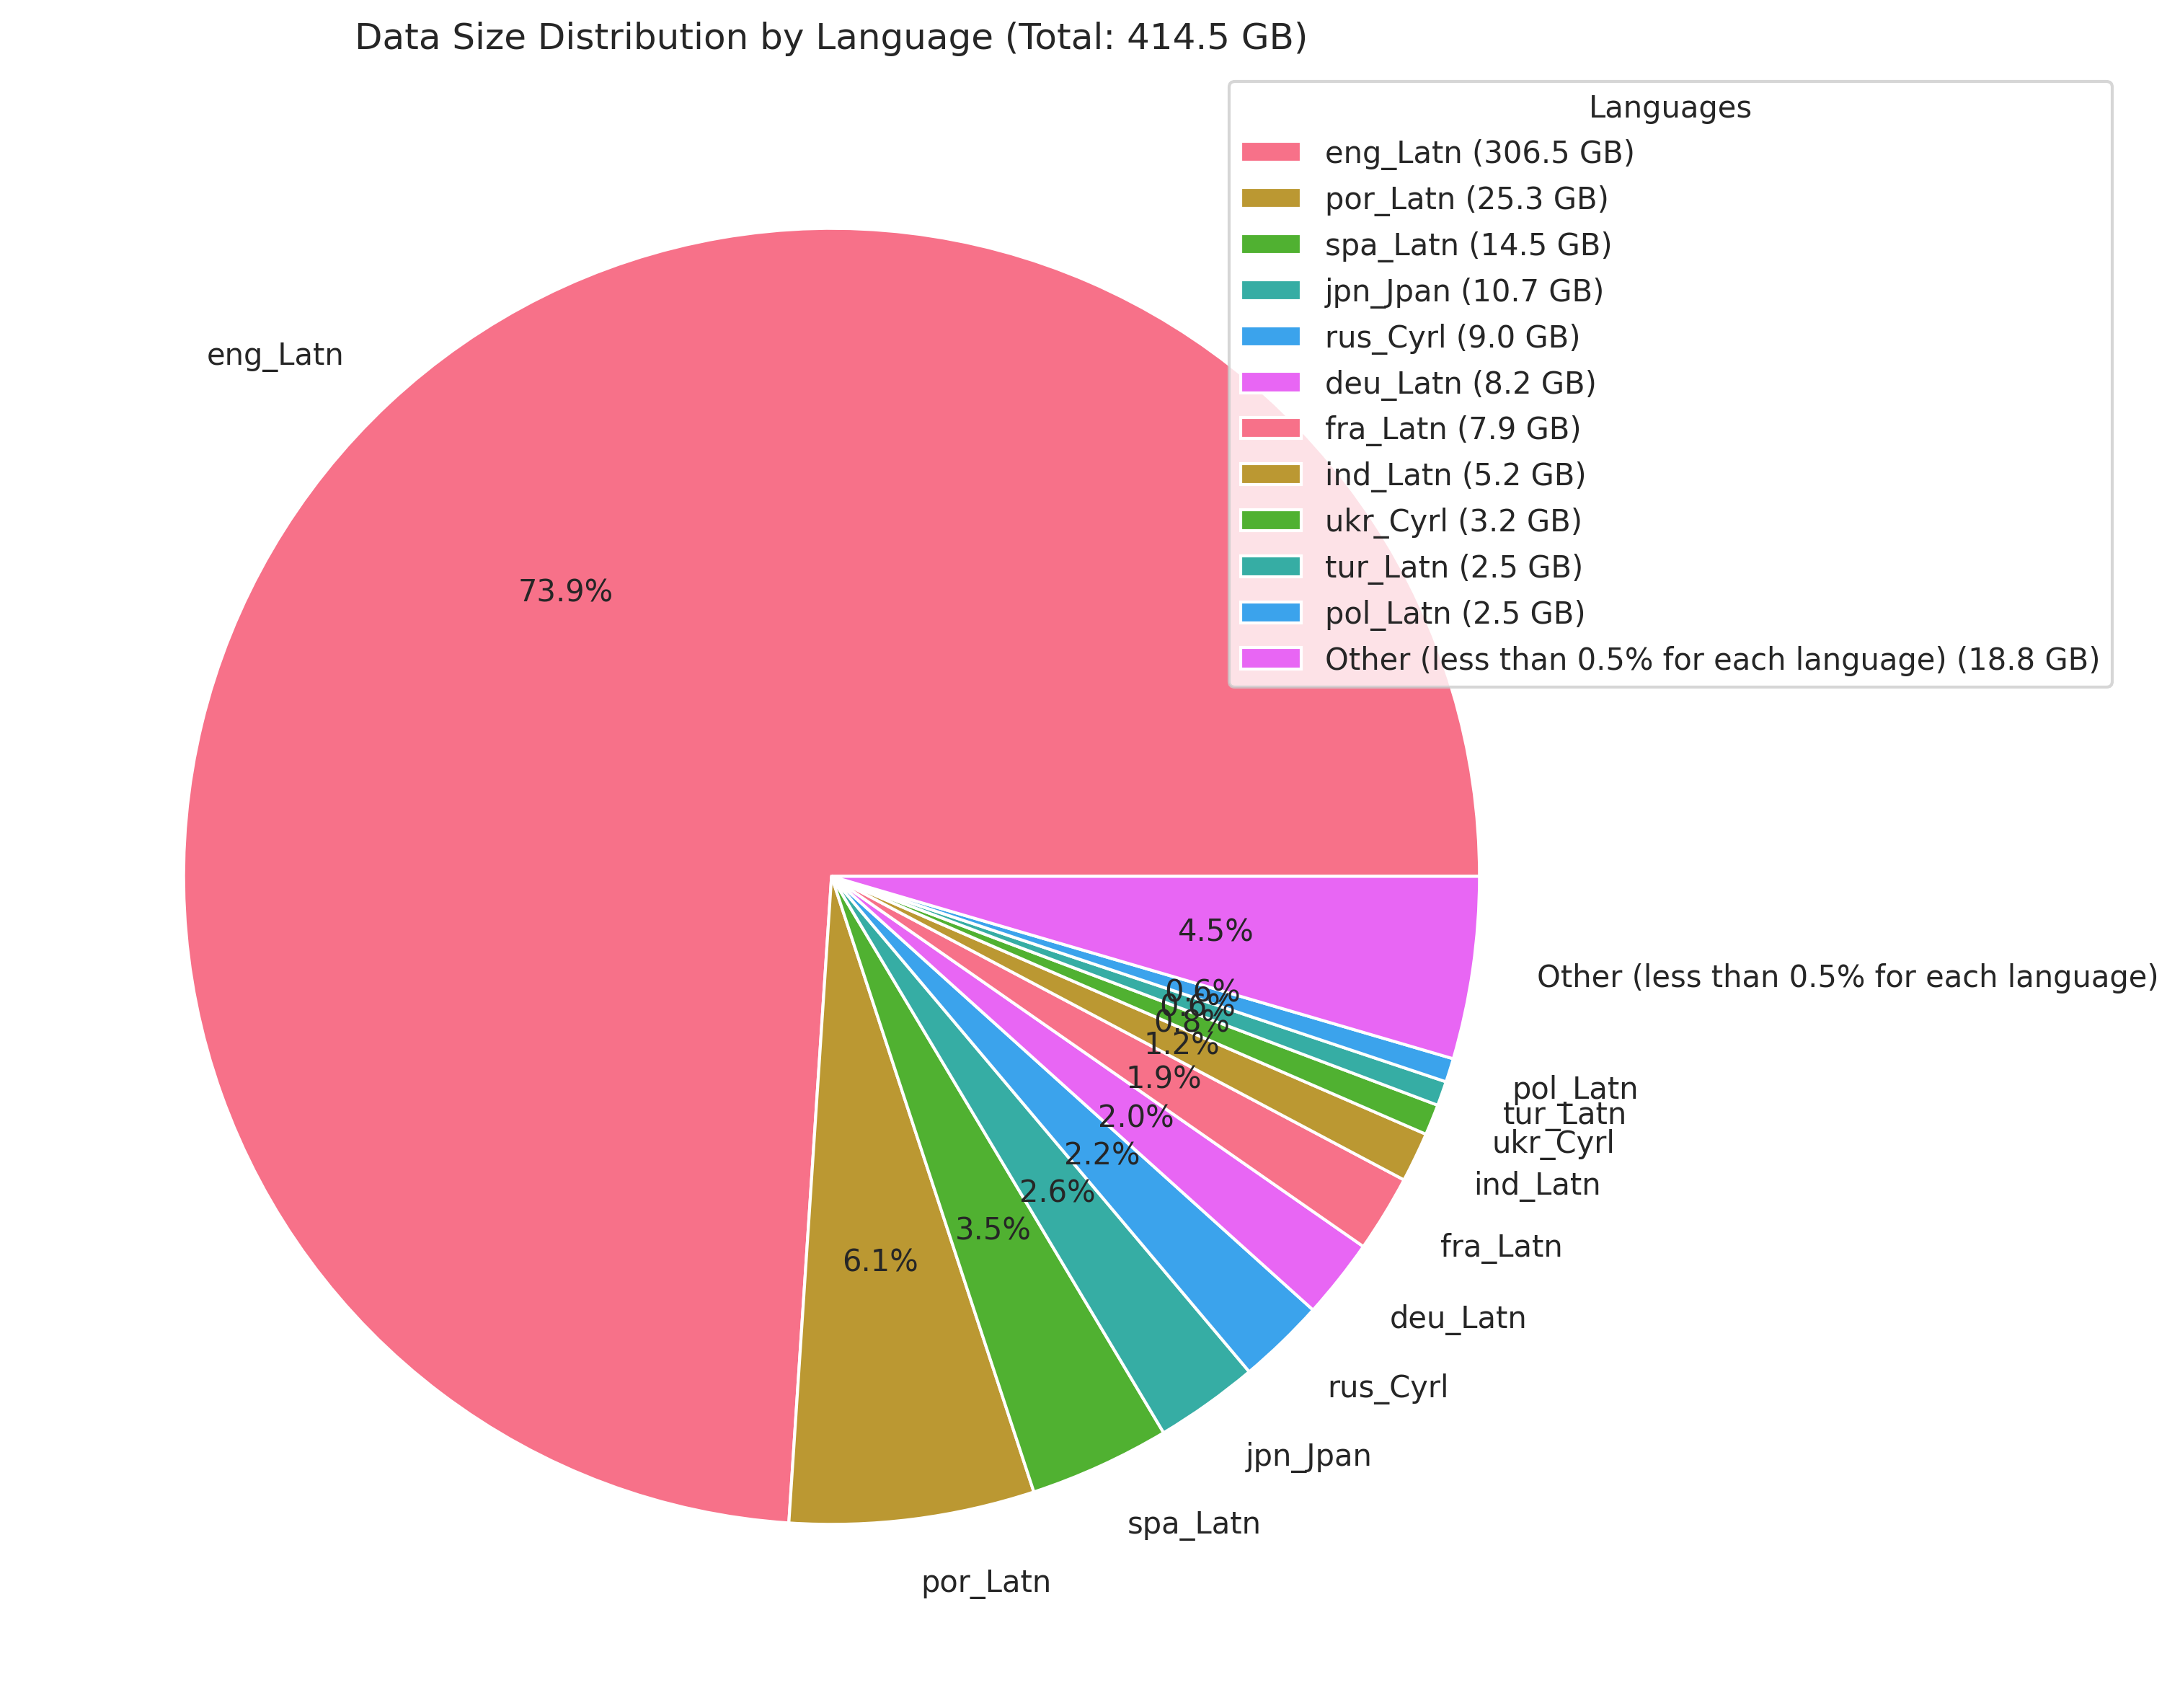

In [33]:
import os
import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Base path for the data
base_path = "/ds-slt/sci-LLM/scilons/unpaywall_texts_pq/unpaywall_texts_pq_3"

# Get all language folders
lang_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

# Calculate sizes for each language
data = []
for lang in lang_folders:
    lang_path = os.path.join(base_path, lang)
    
    # Get all parquet files
    parquet_files = glob.glob(os.path.join(lang_path, "*.parquet"))
    
    # Calculate total size and file counts
    total_size = sum(os.path.getsize(f) for f in parquet_files)
    file_count = len(parquet_files)
    
    # Convert size to GB
    size_gb = total_size / (1024**3)
    
    data.append({
        'Language': lang,
        'Size_GB': size_gb,
        'File_Count': file_count
    })

# Create DataFrame and sort by size
df = pd.DataFrame(data)
df = df.sort_values('Size_GB', ascending=False)

# Calculate percentages
total_size = df['Size_GB'].sum()
df['Percentage'] = (df['Size_GB'] / total_size) * 100

# Filter for languages with >1% share
df_significant = df[df['Percentage'] > 0.5]
df_other = pd.DataFrame([{
    'Language': 'Other (less than 0.5% for each language)',
    'Size_GB': df[df['Percentage'] <= 0.5]['Size_GB'].sum(),
    'File_Count': df[df['Percentage'] <= 0.5]['File_Count'].sum(),
    'Percentage': df[df['Percentage'] <= 0.5]['Percentage'].sum()
}])
df_plot = pd.concat([df_significant, df_other])

# Create pie chart with high DPI
plt.figure(figsize=(12, 8), dpi=300)
plt.pie(df_plot['Size_GB'], labels=df_plot['Language'], autopct='%1.1f%%')
plt.title(f'Data Size Distribution by Language (Total: {total_size:.1f} GB)')

# Create legend labels with GB sizes
legend_labels = [f"{lang} ({size:.1f} GB)" for lang, size in zip(df_plot['Language'], df_plot['Size_GB'])]

# Add legend with GB sizes at the top right
plt.legend(legend_labels, title="Languages", loc="upper right", bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()

# Create directory 
save_dir = "/netscratch/nrauscher/projects/BA-NikolasRauscher/notebooks/figs"
# os.makedirs(save_dir, exist_ok=True)

# Save high resolution figure
plt.savefig(os.path.join(save_dir, 'language_distribution.png'), dpi=300, bbox_inches='tight')

# Print statistics
print("\nLanguage Distribution Statistics:")
print(f"Total size across all languages: {total_size:.1f} GB")
print("\nBreakdown by language:")
print(df.to_string(index=False))

plt.show()


### Metadaten

In [1]:
ls /ds-slt/sci-LLM/scilons/unpaywall_texts_pq/unpaywall_texts_pq_3/eng_Latn/

part-0.parquet*   part-15.parquet*  part-21.parquet*  part-5.parquet*
part-1.parquet*   part-16.parquet*  part-22.parquet*  part-6.parquet*
part-10.parquet*  part-17.parquet*  part-23.parquet*  part-7.parquet*
part-11.parquet*  part-18.parquet*  part-24.parquet*  part-8.parquet*
part-12.parquet*  part-19.parquet*  part-25.parquet*  part-9.parquet*
part-13.parquet*  part-2.parquet*   part-3.parquet*
part-14.parquet*  part-20.parquet*  part-4.parquet*


In [3]:
import duckdb

file_path = "/ds-slt/sci-LLM/scilons/unpaywall_texts_pq/unpaywall_texts_pq_3/eng_Latn/part-*.parquet"


In [4]:
# Schema ermitteln
df_schema = duckdb.sql(f"""
    DESCRIBE SELECT * 
    FROM read_parquet('{file_path}')
""").df()

df_schema

,column_name,column_type,null,key,default,extra
0,text,VARCHAR,YES,None,None,None
1,language_score,VARCHAR,YES,None,None,None
2,source_file_path,VARCHAR,YES,None,None,None
3,source_zip_content_path,VARCHAR,YES,None,None,None
4,doi,VARCHAR,YES,None,None,None
5,authors,VARCHAR,YES,None,None,None
6,title,VARCHAR,YES,None,None,None
7,pdf_md5_hash,VARCHAR,YES,None,None,None
8,publisher,VARCHAR,YES,None,None,None
9,journal,VARCHAR,YES,None,None,None


In [5]:
df_text_stats = duckdb.sql(f"""
    SELECT
        COUNT(*) AS total_rows,
        SUM(CASE WHEN text IS NULL THEN 1 ELSE 0 END) AS text_null_count,
        SUM(CASE WHEN text IS NOT NULL AND TRIM(text) = '' THEN 1 ELSE 0 END) AS text_blank_count
    FROM read_parquet('{file_path}')
""").df()

df_text_stats

,total_rows,text_null_count,text_blank_count
0,26789066,0.0,0.0


In [6]:
df_lang_stats = duckdb.sql(f"""
    SELECT
        COUNT(*) AS total_rows,
        SUM(CASE WHEN language_score IS NULL THEN 1 ELSE 0 END) AS null_count,
        SUM(CASE WHEN TRIM(language_score) = '' THEN 1 ELSE 0 END) AS blank_count
    FROM read_parquet('{file_path}')
""").df()

df_lang_stats

,total_rows,null_count,blank_count
0,26789066,0.0,0.0


## Sprach scores

In [7]:
df_lang_distribution = duckdb.sql(f"""
    SELECT
        approx_quantile(CAST(language_score AS DOUBLE), 0.0) AS min_val,
        approx_quantile(CAST(language_score AS DOUBLE), 0.25) AS q1,
        approx_quantile(CAST(language_score AS DOUBLE), 0.5) AS median,
        approx_quantile(CAST(language_score AS DOUBLE), 0.75) AS q3,
        approx_quantile(CAST(language_score AS DOUBLE), 1.0) AS max_val
    FROM read_parquet('{file_path}')
    WHERE language_score IS NOT NULL
      AND TRIM(language_score) <> ''
      AND TRY_CAST(language_score AS DOUBLE) IS NOT NULL
""").df()

df_lang_distribution

,min_val,q1,median,q3,max_val
0,0.082792,0.781861,0.869097,0.93063,1.0


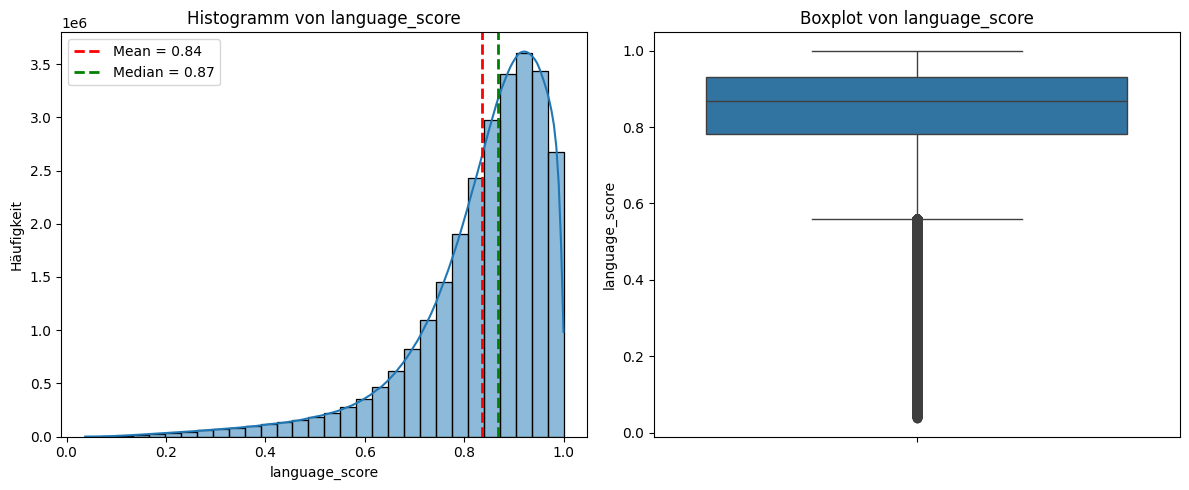

In [9]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Daten abfragen: Nur gültige numerische Werte
df_lang_scores = duckdb.sql(f"""
    SELECT
        TRY_CAST(language_score AS DOUBLE) AS lang_score
    FROM read_parquet('{file_path}')
    WHERE language_score IS NOT NULL
      AND TRIM(language_score) <> ''
      AND TRY_CAST(language_score AS DOUBLE) IS NOT NULL
""").df()

# 2) Kennwerte berechnen
mean_val = df_lang_scores["lang_score"].mean()
median_val = df_lang_scores["lang_score"].median()

# 3) Figure und Subplots anlegen (1 Zeile, 2 Spalten)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# -- Subplot 1: Histogramm --
sns.histplot(data=df_lang_scores, x="lang_score", bins=30, kde=True, ax=axes[0])
axes[0].axvline(mean_val,   color='red',   linestyle='--', linewidth=2, label=f"Mean = {mean_val:.2f}")
axes[0].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f"Median = {median_val:.2f}")
axes[0].set_title("Histogramm von language_score")
axes[0].set_xlabel("language_score")
axes[0].set_ylabel("Häufigkeit")
axes[0].legend()

# -- Subplot 2: Boxplot --
sns.boxplot(y="lang_score", data=df_lang_scores, ax=axes[1])
axes[1].set_title("Boxplot von language_score")
axes[1].set_ylabel("language_score")

plt.tight_layout()
plt.show()

In [40]:
import duckdb
import pandas as pd
from IPython.display import display, HTML
import time

file_path = "/ds-slt/sci-LLM/scilons/unpaywall_texts_pq/unpaywall_texts_pq_3/eng_Latn/part-*.parquet"

# Funktion zum Kürzen langer Texte für die Anzeige
def truncate_text(text, max_length=200):
    if isinstance(text, str):
        if len(text) > max_length:
            return text[:max_length] + "..."
        return text
    return ""

# Verschiedene Sprachscore-Bereiche definieren
score_ranges = [
    (0.4, 0.5, "40-50%"),
    (0.3, 0.4, "30-40%"),
    (0.2, 0.3, "20-30%"),
    (0.1, 0.2, "10-20%"),
    (0.0, 0.1, "0-10%")
]

# Ergebnisse für alle Bereiche in einem Durchgang abfragen
all_results = []

for lower, upper, label in score_ranges:
    print(f"Suche Beispiele für Sprachscore {label}...")
    start_time = time.time()
    
    # Abfrage für diesen Bereich
    query = f"""
        SELECT 
            title,
            CAST(language_score AS DOUBLE) AS language_score,
            text
        FROM read_parquet('{file_path}')
        WHERE TRY_CAST(language_score AS DOUBLE) >= {lower} 
          AND TRY_CAST(language_score AS DOUBLE) < {upper}
        ORDER BY RANDOM()
        LIMIT 5
    """
    
    # Abfrage ausführen
    df_examples = duckdb.sql(query).df()
    
    # Bereichslabel hinzufügen
    df_examples['score_range'] = label
    
    # Zum Gesamtergebnis hinzufügen
    all_results.append(df_examples)
    
    elapsed_time = time.time() - start_time
    print(f"  Gefunden: {len(df_examples)} Einträge in {elapsed_time:.2f} Sekunden")

# Alle Beispiele zusammenführen
df_all = pd.concat(all_results, ignore_index=True)

# Text für die Anzeige kürzen
df_all['text_display'] = df_all['text'].apply(lambda x: truncate_text(x))

# Nach Sprachscore-Bereich gruppieren und anzeigen
for label in [r[2] for r in score_ranges]:
    df_group = df_all[df_all['score_range'] == label]
    
    if not df_group.empty:
        print(f"\n\n=== Beispiele für Sprachscore {label} ===")
        print(f"Anzahl gefundener Einträge: {len(df_group)}")
        display(df_group[['title', 'language_score', 'text_display']])
    else:
        print(f"\n\n=== Keine Beispiele für Sprachscore {label} gefunden ===")

Suche Beispiele für Sprachscore 40-50%...
  Gefunden: 5 Einträge in 346.78 Sekunden
Suche Beispiele für Sprachscore 30-40%...
  Gefunden: 5 Einträge in 353.79 Sekunden
Suche Beispiele für Sprachscore 20-30%...
  Gefunden: 5 Einträge in 349.76 Sekunden
Suche Beispiele für Sprachscore 10-20%...
  Gefunden: 5 Einträge in 352.96 Sekunden
Suche Beispiele für Sprachscore 0-10%...
  Gefunden: 5 Einträge in 352.86 Sekunden


=== Beispiele für Sprachscore 40-50% ===
Anzahl gefundener Einträge: 5


,title,language_score,text_display
0,Stability inequalities and universal Schubert calculus of rank 2,0.443050,"Stability inequalities and universal Schubert calculus of rank 2\n\n\nThe goal of the paper is to introduce a version of Schubert calculus for each dihedral reflection group W . That is, to each ""suffici..."
1,A Rule-Based Method for Homograph Disambiguation in Brazilian Portuguese Text-to-Speech Systems,0.422143,"A Rule-Based Method for Homograph Disambiguation in Brazilian Portuguese Text-to-Speech Systems\n\nKeywords: Text-to-Speech, Homograph, Speech Synthesis, Morphosyntactic Analysis, Semantic Analysis\n\nThi..."
2,On a counterexample related to weighted weak type estimates for singular integrals,0.492591,"On a counterexample related to weighted weak type estimates for singular integrals\n\n\nWe show that the Hilbert transform does not map L1⁢(MΦ⁢w) to L1,∞⁢(w) for every Young function Φ growing more slowl..."
3,ОСОБЛИВОСТІ ЕКСПРЕСІЇ FOX-1 У ЩИТОПОДІБНІЙ ЗАЛОЗІ ЩУРІВ ПІСЛЯ ПРЕНАТАЛЬНОЇ ДІЇ ДЕКСАМЕТАЗОНУ,0.487296,"ОСОБЛИВОСТІ ЕКСПРЕСІЇ FOX-1 У ЩИТОПОДІБНІЙ ЗАЛОЗІ ЩУРІВ ПІСЛЯ ПРЕНАТАЛЬНОЇ ДІЇ ДЕКСАМЕТАЗОНУ\n\nKeywords: thyroid gland, dexamethasone, rats, immunohistochemistry, Fox-1 antibodies\n\nМета дослідження -вс..."
4,DEPARTMENT OF THE INTERIOR,0.430888,DEPARTMENT OF THE INTERIOR\n\n\nILLUSTRATIONS.\n\nPage \n\nBy G. C. MARTIN.\n\nThis volume is the fourteenth of a series of annual bulletins * treating of the mining industry of Alaska and summarizing the resu...




=== Beispiele für Sprachscore 30-40% ===
Anzahl gefundener Einträge: 5


,title,language_score,text_display
5,Effect of Baricitinib and Adalimumab in Reducing Pain and Improving Function in Patients with Rheumatoid Arthritis in Low Disease Activity: Exploratory Analyses from RA-BEAM,0.344475,Effect of Baricitinib and Adalimumab in Reducing Pain and Improving Function in Patients with Rheumatoid Arthritis in Low Disease Activity: Exploratory Analyses from RA-BEAM\n\n\nAbsenteeism (%) 10 7.1 4...
6,THREE CANDIDATE PLURALITY IS STABLEST FOR SMALL CORRELATIONS,0.380990,"THREE CANDIDATE PLURALITY IS STABLEST FOR SMALL CORRELATIONS\n\n\nUsing the calculus of variations, we prove the following structure theorem for noise stable partitions: a partition of n-dimensional Eucl..."
7,,0.384035,"Cordycepin, a major bioactive component of Cordyceps militaris, ameliorates diabetes-induced testicular damage through the Sirt1/Foxo3a pathway \n\nTao Huang, Yanfen Zhou, Xuanzhao Lu, Chenglun Tang, Ch..."
8,Decomposing Complete 3-Uniform Hypergraph   3 44 K into 7-cycles,0.331644,"Decomposing Complete 3-Uniform Hypergraph   3 44 K into 7-cycles\n\nKeywords: Uniform hypergraph, 7-cycle, Cycle decomposition\n\nOn the basic of the definition of Hamiltonian cycle defined by Katona-Ki..."
9,Some distributional results for Poisson-Voronoi tessellations,0.300199,"Some distributional results for Poisson-Voronoi tessellations\n\nKeywords: Voronoi tessellation, Poisson process, random measure, Palm distribution, typical face, typical edge 2000 Mathematics Subject C..."




=== Beispiele für Sprachscore 20-30% ===
Anzahl gefundener Einträge: 5


,title,language_score,text_display
10,Existence of Subharmonic Periodic Solutions to a Class of Second-Order Non-Autonomous Neutral Functional Differential Equations,0.296487,Existence of Subharmonic Periodic Solutions to a Class of Second-Order Non-Autonomous Neutral Functional Differential Equations\n\n\nBy introducing subdifferentiability of lower semicontinuous convex fun...
11,Last Step towards Macrocyclic Glycoterpenoids Having Isosteviol and Glucosamine Moieties,0.285825,"Last Step towards Macrocyclic Glycoterpenoids Having Isosteviol and Glucosamine Moieties\n\nKeywords: Terpenoids, isosteviol, glucosamine, glycoconjugates, glycoterpenoids Терпеноиды, изостевиол, глюкоз..."
12,"Radii of univalence, starlikeness, and convexity",0.204020,"Radii of univalence, starlikeness, and convexity\n\n\nLet a function f(s) = z + £ a z 1 be regular in the disk \n\n""\n\n|s| < 1 . The radius of univalence 0.16 1 * ... of the family of / with \a I 5 n (n > 2..."
13,FORMULAS FOR TAMELY RAMIFIED SUPERCUSPIDAL CHARACTERS OF GL 3,0.277644,"FORMULAS FOR TAMELY RAMIFIED SUPERCUSPIDAL CHARACTERS OF GL 3\n\nKeywords: Characters, supercuspidal, base change\n\nLet F denote a p-adic local field of residual characteristic p = 3. This article gives ..."
14,,0.270682,Supplementary table\n\nReliability of the self-rated fall risk questionnaire self-rated FRQ retest-self-rated FRQ Test-retest reliability (Kappa statistics) p value yes no \n\n\n\n\n Abbreviations: p value ...




=== Beispiele für Sprachscore 10-20% ===
Anzahl gefundener Einträge: 5


,title,language_score,text_display
15,PAR volume 49 issue 1-2 Cover and Front matter,0.184365,"PAR volume 49 issue 1-2 Cover and Front matter\n\nKeywords: OPTOIL: synthetic, non-sticky immersion oil. CRISTALITE & CLEARMOUNT: synthetic, colourless, neutral mountants high quality, reliability, and ..."
16,,0.129851,"Class functions, linking characters to the semisimple group algebra \n\n\n\t\tXII | Contents\n\t\t3.4.2\tFactor sets, second group cohomology | 121\n\t\t3.4.3\tClifford's main theorem | 126\n\t\t3.4.4\tSmall and big i..."
17,EUROPEAN JOURNAL OF I MMUNOl OGY ASSOCIATED WllH THE EUROPEAN FEDERATION OF IMMUNOLOGICAL SOClETlW Chairman: Harald von Boehmer,0.177146,EUROPEAN JOURNAL OF I MMUNOl OGY ASSOCIATED WllH THE EUROPEAN FEDERATION OF IMMUNOLOGICAL SOClETlW Chairman: Harald von Boehmer\n\n\nIn the USA/Canada Telephone: 800-683-3695 Telephone: ++49 (0) \n\n\n\n Fo...
18,"Synthesis of fluorinated pyrrolizidine, indolizidine and quinolizidine derivatives",0.184098,"Synthesis of fluorinated pyrrolizidine, indolizidine and quinolizidine derivatives\n\nKeywords: fluorine, pyrrolizidine, indolizidine, quinolizidine alkaloids, synthetic strategies\n\nUkrainica Bioorganic..."
19,Space reserved for Certified Consulting Meteorologists*,0.112703,Space reserved for Certified Consulting Meteorologists*\n\n\nCertified Consulting Meteorologists\n\nCertified Consulting Meteorologist: The certification program of the American Meteorological Society is a...




=== Beispiele für Sprachscore 0-10% ===
Anzahl gefundener Einträge: 5


,title,language_score,text_display
20,CONTENTS OF MAIN CHAPTERS,0.085160,CONTENTS OF MAIN CHAPTERS\n\n\n\n\n\n References at the end of the Chapters and Annexes. Note: References are numbered by subchapters; the figures following the slash indicate their sequence within the sub...
21,"Europhysics Conference Abstracts A new EPS publication, Europhysics Conference Abstracts (ECA), is going to provide rapid information on active research as presented at scientific conferences. Initially conferences or ganized by EPS, its Divisions, Sections or Interdivisional Groups will be covered by issues of ECA appearing at irregular intervals and each con taining the abstracts of a single con ference. Further details may be obtained from the Secretariat, Euro pean Physical Society",0.075722,"Europhysics Conference Abstracts A new EPS publication, Europhysics Conference Abstracts (ECA), is going to provide rapid information on active research as presented at scientific conferences. Initial..."
22,Published in Association with the European Federation of Clinical Chemistry and Laboratory Medicine (EFLM),0.074185,Published in Association with the European Federation of Clinical Chemistry and Laboratory Medicine (EFLM)\n\n\nMedicine (SEQC). CCLM is affi liated with the Australasian Association of Clinical Biochemi...
23,,0.089099,"Table 5 .\n\n 5 1 Average GDP Growth in Zambia 88 \n\n\n\tIllustrations\t\n\tFigures\t\n\t2.1 Sudan's Oil Production and Consumption,\t\n\t1998-2008\t26\n\t3.1 Imports from Africa\t35\n\t3.2 Primary Commodity Prices\t38\n\t3..."
24,Hotspots of mite new species discovery: Trombidiformes (2013–2015),0.087552,"Hotspots of mite new species discovery: Trombidiformes (2013–2015)\n\nKeywords: Mites, Trombidiformes, new species, hotspots, type locality, type depository female (UTI, CR-IEA-SD11L-1), from Consolida ..."


In [11]:
df_path_stats = duckdb.sql(f"""
    SELECT
        COUNT(*) AS total_rows,
        SUM(
            CASE 
                WHEN source_file_path IS NULL OR TRIM(source_file_path) = '' 
                THEN 1 
                ELSE 0 
            END
        ) AS source_file_path_missing,
        SUM(
            CASE 
                WHEN source_zip_content_path IS NULL OR TRIM(source_zip_content_path) = '' 
                THEN 1 
                ELSE 0 
            END
        ) AS source_zip_content_path_missing

    FROM read_parquet('{file_path}')
""").df()

df_path_stats

,total_rows,source_file_path_missing,source_zip_content_path_missing
0,26789066,0.0,0.0


,column_name,total_rows,present_count,present_pct
0,language_score,26789066,26789066.0,100.00%
1,source_file_path,26789066,26789066.0,100.00%
2,source_zip_content_path,26789066,26789066.0,100.00%
3,doi,26789066,13610998.0,50.81%
4,authors,26789066,24509357.0,91.49%
5,title,26789066,24639973.0,91.98%
6,pdf_md5_hash,26789066,22570689.0,84.25%
7,publisher,26789066,15454055.0,57.69%
8,journal,26789066,106.0,0.00%
9,journal_abbrev,26789066,0.0,0.00%


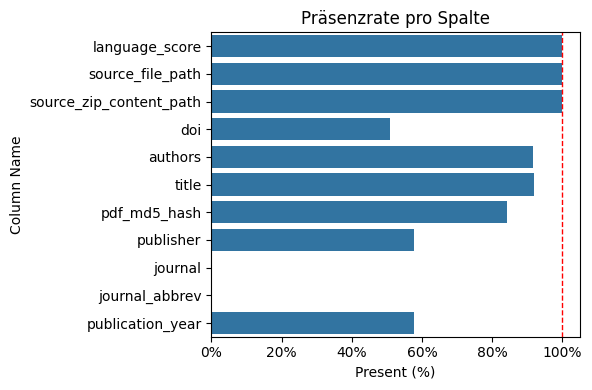

In [2]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

file_path = "/ds-slt/sci-LLM/scilons/unpaywall_texts_pq/unpaywall_texts_pq_3/eng_Latn/part-*.parquet"

# 1) Gesamte Zeilenanzahl einmalig bestimmen
df_total = duckdb.sql(f"SELECT COUNT(*) AS total_rows FROM read_parquet('{file_path}')").df()
total_rows = df_total["total_rows"][0]

# 2) Schema abfragen, 'text' ausschließen
df_schema = duckdb.sql(f"""
    DESCRIBE SELECT * FROM read_parquet('{file_path}')
""").df()
df_schema = df_schema[df_schema["column_name"] != "text"]

results = []

for col_name, col_type in zip(df_schema["column_name"], df_schema["column_type"]):
    if col_name == "publication_year":
        # publication_year: präsent, wenn NICHT NULL und != 0
        query = f"""
            SELECT
                SUM(CASE WHEN {col_name} IS NOT NULL AND {col_name} != 0 THEN 1 ELSE 0 END) AS present_count
            FROM read_parquet('{file_path}')
        """
    elif "CHAR" in col_type.upper():
        # String-Spalten: präsent, wenn NICHT NULL und TRIM(...) != ''
        query = f"""
            SELECT
                SUM(CASE WHEN {col_name} IS NOT NULL AND TRIM({col_name}) != '' THEN 1 ELSE 0 END) AS present_count
            FROM read_parquet('{file_path}')
        """
    else:
        # Andere Spalten: präsent, wenn NICHT NULL
        query = f"""
            SELECT
                SUM(CASE WHEN {col_name} IS NOT NULL THEN 1 ELSE 0 END) AS present_count
            FROM read_parquet('{file_path}')
        """
    
    df_col = duckdb.sql(query).df()
    present_count = df_col["present_count"][0]
    
    present_pct_num = (present_count / total_rows * 100) if total_rows else 0
    present_pct_str = f"{present_pct_num:.2f}%"

    results.append({
        "column_name": col_name,
        "total_rows": total_rows,
        "present_count": present_count,
        "present_pct_num": present_pct_num,  # für den Plot
        "present_pct": present_pct_str        # Textformat
    })

df_stats = pd.DataFrame(results)

# 3) Tabelle anzeigen (ohne column_type)
df_stats_table = df_stats[["column_name", "total_rows", "present_count", "present_pct"]]
display(df_stats_table)  # oder print(df_stats_table)

# 4) Kleines Bar-Chart in Prozent
plt.figure(figsize=(6, 4))
sns.barplot(
    data=df_stats,
    x="present_pct_num",
    y="column_name",
    orient="h"
)

plt.title("Präsenzrate pro Spalte")
plt.xlabel("Present (%)")
plt.ylabel("Column Name")

# X-Achse als Prozent formatieren
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())

# Linie bei 100% hinzufügen
plt.axvline(x=100, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

In [17]:
import duckdb
import pandas as pd

file_path = "/ds-slt/sci-LLM/scilons/unpaywall_texts_pq/unpaywall_texts_pq_3/eng_Latn/part-*.parquet"

# Beispielabfrage, die die ersten 5 Zeilen ausgibt
query = "SELECT * FROM read_parquet('{}') LIMIT 5".format(file_path)

# Abfrage ausführen und Ergebnis in einem Pandas DataFrame speichern
df = duckdb.sql(query).df()

# Funktion definieren, um die ersten 200 Zeichen des Textes anzuzeigen
def truncate_text(text):
    if isinstance(text, str):
        return text[:200]
    else:
        return ""  # Oder eine andere geeignete Behandlung für nicht-String-Werte

# Funktion auf die 'text'-Spalte anwenden
df['text'] = df['text'].apply(truncate_text)

# DataFrame im Notebook anzeigen
display(df)

,text,language_score,source_file_path,source_zip_content_path,doi,authors,title,pdf_md5_hash,publisher,journal,journal_abbrev,publication_year
0,Neotectonic crustal extension in SW Bulgaria\n...,0.7584828910456287,unpaywall/0096/tei.zip,75/37/1f/51/75371f51-b4fb-44f9-bae2-373fd9377c...,,,Neotectonic crustal extension in SW Bulgaria,89EA9696669FEB1C4A10F6B54E3891F0,,,,0
1,Parity anomaly and Landau-level lasing in stra...,0.8842030232447939,unpaywall/0064/tei.zip,ad/98/8c/7b/ad988c7b-c3e7-44b9-8f63-7291616a16...,,"Schomerus Henning, Halpern Nicole Yunger",Parity anomaly and Landau-level lasing in stra...,,,,,2023
2,On Unemployment Inflow and Outflow in Urban Ch...,0.9324237873406978,unpaywall/0096/tei.zip,75/d0/fe/68/75d0fe68-6880-4c16-9712-75fecf94c0...,10.1080/00343400600660748,"Zhongmin Wu, Shujie Yao",On Unemployment Inflow and Outflow in Urban China,2A4CDD09ED60B23562EB4EA37E5CF705,Informa UK Limited,,,2006
3,Long-term results of aggressive hemiarch repla...,0.8304926479463831,unpaywall/0032/tei.zip,75/e3/4c/36/75e34c36-aa99-4b68-b650-f904bcf7a1...,10.1016/j.jtcvs.2014.05.093,"MD Bartosz Rylski, MD Rita K Milewski, MD Jose...",Long-term results of aggressive hemiarch repla...,090C0FDF1BD39BD908A4EC55AF35D067,Elsevier BV,,,2014
4,Parity anomaly and Landau-level lasing in stra...,0.8826354023585553,unpaywall/0064/tei.zip,ad/98/8c/7b/ad988c7b-c3e7-44b9-8f63-7291616a16...,,"Henning Schomerus, Nicole Yunger Halpern",Parity anomaly and Landau-level lasing in stra...,A3297D61851DFE3F720BBF4F3EB6D20B,,,,2013


## Analyse der Publikationsjahre

AttributeError: This method only works with the ScalarFormatter

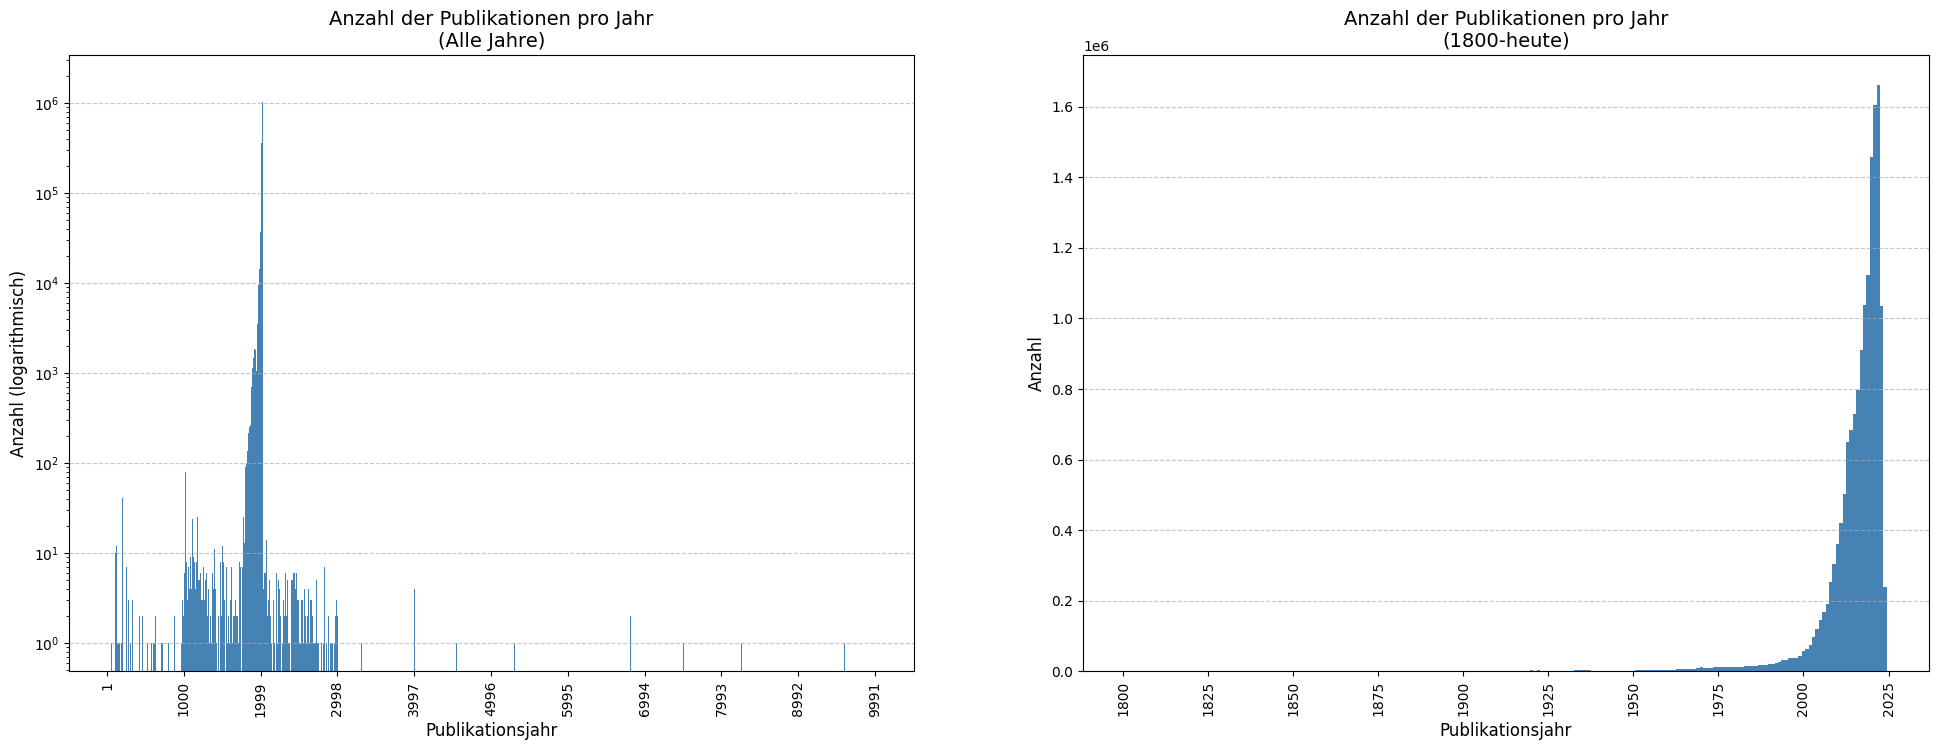

In [18]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.ticker as ticker

# Datenpfad
file_path = "/ds-slt/sci-LLM/scilons/unpaywall_texts_pq/unpaywall_texts_pq_3/eng_Latn/part-*.parquet"

# Aktuelles Jahr für Filter
current_year = datetime.now().year

# Abfrage: Alle Publikationen nach Jahr gruppieren (ohne Einschränkung)
query_all = f"""
    SELECT 
        publication_year AS year,
        COUNT(*) AS publication_count
    FROM read_parquet('{file_path}')
    WHERE 
        publication_year IS NOT NULL 
        AND publication_year != 0
        -- Keine Filterung für fehlerhafte Jahre, um diese zu zeigen
    GROUP BY publication_year
    ORDER BY publication_year
"""

# Abfrage: Publikationen nach Jahr gruppieren (mit Einschränkung 1800-heute)
query_filtered = f"""
    SELECT 
        publication_year AS year,
        COUNT(*) AS publication_count
    FROM read_parquet('{file_path}')
    WHERE 
        publication_year IS NOT NULL 
        AND publication_year != 0
        AND publication_year >= 1800
        AND publication_year <= {current_year}
    GROUP BY publication_year
    ORDER BY publication_year
"""

# Abfragen ausführen
df_years_all = duckdb.sql(query_all).df()
df_years_filtered = duckdb.sql(query_filtered).df()

# Zwei Plots nebeneinander erstellen, größere Figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

# Plot 1: Alle Jahre - Liniendiagramm statt Balkendiagramm
ax1.bar(df_years_all["year"], df_years_all["publication_count"], color="steelblue", width=1)
ax1.set_title("Anzahl der Publikationen pro Jahr\n(Alle Jahre)", fontsize=14)
ax1.set_xlabel("Publikationsjahr", fontsize=12)
ax1.set_ylabel("Anzahl (logarithmisch)", fontsize=12)
ax1.set_yscale('log')  # Logarithmische Y-Achse
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Dynamische Schrittweite für x-Achse basierend auf der Anzahl der Jahre
years_range_all = df_years_all["year"].max() - df_years_all["year"].min()
step_all = max(50, years_range_all // 10)  # Größere Schritte für bessere Lesbarkeit
ax1.set_xticks(range(int(df_years_all["year"].min()), int(df_years_all["year"].max()) + 1, step_all))
ax1.set_xticklabels(range(int(df_years_all["year"].min()), int(df_years_all["year"].max()) + 1, step_all), rotation=90)

# Plot 2: Gefilterte Jahre (1800-heute) - Liniendiagramm statt Balkendiagramm
ax2.bar(df_years_filtered["year"], df_years_filtered["publication_count"], color="steelblue", width=1)
ax2.set_title("Anzahl der Publikationen pro Jahr\n(1800-heute)", fontsize=14)
ax2.set_xlabel("Publikationsjahr", fontsize=12)
ax2.set_ylabel("Anzahl", fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Dynamische Schrittweite für gefilterte Jahre
years_range_filtered = df_years_filtered["year"].max() - df_years_filtered["year"].min()
step_filtered = max(25, years_range_filtered // 10)  # Größere Schritte für bessere Lesbarkeit
ax2.set_xticks(range(df_years_filtered["year"].min(), df_years_filtered["year"].max() + 1, step_filtered))
ax2.set_xticklabels(range(df_years_filtered["year"].min(), df_years_filtered["year"].max() + 1, step_filtered), rotation=90)

# Y-Achse als "absolute Zahl" (keine wissenschaftliche Notation) für beide Plots
ax1.ticklabel_format(style='plain', axis='y')
ax2.ticklabel_format(style='plain', axis='y')

# Optional: Tausender-Trennzeichen für bessere Lesbarkeit
ax1.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Mehr Platz unten für die rotierten x-Achsen-Labels
plt.subplots_adjust(bottom=0.15)

plt.tight_layout()
plt.show()

# Statistiken anzeigen
print("\nAlle Jahre:")
print(df_years_all)
print("\nJahre von 1800 bis heute:")
print(df_years_filtered)

# Analyse eines bestimmten Titels


In [36]:
import duckdb
import pandas as pd

file_path = "/ds-slt/sci-LLM/scilons/unpaywall_texts_pq/unpaywall_texts_pq_3/eng_Latn/part-*.parquet"

title_to_find = "Parity anomaly and Landau-level lasing in strained photonic honeycomb lattices"

query = f"""
SELECT * -- Alle Spalten auswählen
FROM read_parquet('{file_path}')
WHERE title = '{title_to_find}'
"""

df = duckdb.sql(query).df()

if not df.empty:
    pd.set_option('display.max_colwidth', None)  # Vollständigen Text anzeigen
    display(df)
else:
    print(f"Kein Artikel mit dem Titel '{title_to_find}' gefunden.")

text  \
0  Parity anomaly and Landau-level lasing in strained photonic honeycomb lattices\n\n\nWe describe the formation of highly degenerate, Landau-level-like amplified states in a strained photonic honeycomb lattice in which amplification breaks the sublattice symmetry. As a consequence of the parity anomaly, the zeroth Landau level is localized on a single sublattice and possesses an enhanced or reduced amplification rate. The spectral properties of the higher Landau levels are constrained by a generalized time-reversal symmetry. In the setting of two-dimensional photonic crystal lasers, the anomaly directly affects the mode selection and lasing threshold while in three-dimensional photonic lattices it can be probed via beam dynamics.\n\nNonuniform deformations of the honeycomb lattice of graphene result in a pseudomagnetic field which deflects particles in analogy to the Lorentz force, with small amounts of strain producing fields that are large enough to create well-defined Landau levels in the low-energy range of the spectrum, in absence of any physical magnetic field guinea ; vozmediano ; levy ; yan . Here we describe how the addition of gain in an analogous photonic setting results in the formation of highly degenerate amplifying Landau levels, which can provide the platform for a laser with macroscopic mode competition. The spectral properties of these levels become intriguing when the gain breaks the sublattice symmetry. Due to the parity anomaly jackiw ; semenoff ; haldane , the amplification of the zeroth Landau level is dictated by one of the two sublattices, which here is selected depending on the strain orientation. Moreover, a reflection symmetry enforces that the instances of this level in the two 𝐤-space valleys behave identically. In contrast, the higher Landau levels are constrained by a generalized time-reversal symmetry. Their amplification rate equals the average rate on the two sublattices, up to a finite threshold of the imbalance at which two levels coalesce and their rates bifurcate.\n\nThese observations allow to detect the parity anomaly via the anomalous amplification or decay of the zeroth Landau level. When the system is operated as a two-dimensional photonic crystal laser, the lasing threshold is set either by the zeroth or by the first Landau level, with the selection dictated by the strain orientation and signature of the amplification imbalance. We also describe how the anomalous behavior of the zeroth Landau level can be probed via the beam dynamics in a three-dimensional photonic lattice.\n\n (Color online) (a) Segment of a honeycomb lattice, with vertices representing states in a two-dimensional photonic crystal or weakly coupled optical fibers in a three-dimensional setting. (b) Sketch of a deformed arrangement which results in a constant pseudomagnetic field. (c) We investigate the interplay of this field with amplification and absorption that breaks the sublattice symmetry. The two sublattices A and B have amplification rates γA and γB, respectively (negative values correspond to absorption). The pseudomagnetic field resulting from the strain is modeled via smooth coupling functions tl whose definition (5) involves the bond vectors 𝝆l, l=1,2,3.\n\n (Color online) Dependence of the Landau level spectrum (10), (13) on the amplification imbalance γ=(γA−γB)/2, for strain leading to a pseudomagnetic field of strength β. (a) Real part, which vanishes for the zeroth Landau level, as well as for the other Landau levels beyond their bifurcation thresholds γn, Eq. (14). (b) Imaginary part, which becomes finite beyond the bifurcation. Because of the parity anomaly, the zeroth Landau level breaks the symmetry of the spectrum as it is located on the A sublattice for β>0 (thick solid line) while it is located on the B sublattice for β<0 (thin dashed line). The circles indicate the lasing threshold when |γ| is increased at fixed average absorption γ¯=−γ1. For γ>0 this threshold is set by the zeroth 

---

# Analyse der Duplikate nach dem source_zip_content_path

In [4]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Datenpfad
file_path = "/ds-slt/sci-LLM/scilons/unpaywall_texts_pq/unpaywall_texts_pq_3/eng_Latn/part-*.parquet"

# 1. Zählen, wie oft jeder source_zip_content_path vorkommt
query_duplicates = f"""
    SELECT 
        source_zip_content_path,
        COUNT(*) AS occurrence_count
    FROM read_parquet('{file_path}')
    WHERE source_zip_content_path IS NOT NULL AND TRIM(source_zip_content_path) != ''
    GROUP BY source_zip_content_path
    HAVING COUNT(*) > 1
    ORDER BY COUNT(*) DESC
"""

# Abfrage ausführen
df_duplicates = duckdb.sql(query_duplicates).df()

# 2. Gesamtstatistik über Duplikate
total_rows_query = f"SELECT COUNT(*) AS total_rows FROM read_parquet('{file_path}')"
total_rows = duckdb.sql(total_rows_query).df()['total_rows'][0]

duplicate_paths_count = len(df_duplicates)
total_duplicate_rows = df_duplicates['occurrence_count'].sum()
unique_paths_count = duckdb.sql(f"""
    SELECT COUNT(DISTINCT source_zip_content_path) 
    FROM read_parquet('{file_path}')
    WHERE source_zip_content_path IS NOT NULL AND TRIM(source_zip_content_path) != ''
""").df().iloc[0, 0]

# 3. Ergebnisse anzeigen
print(f"Gesamtzahl der Datensätze: {total_rows:,}")
print(f"Anzahl eindeutiger ZIP-Inhaltspfade: {unique_paths_count:,}")
print(f"Anzahl der ZIP-Inhaltspfade mit Duplikaten: {duplicate_paths_count:,}")
print(f"Gesamtzahl der Zeilen mit dupliziertem ZIP-Inhaltspfad: {total_duplicate_rows:,}")
print(f"Prozentualer Anteil der Duplikate: {(total_duplicate_rows/total_rows)*100:.2f}%")

# 4. Die Top-10 am häufigsten duplizierten ZIP-Inhaltspfade anzeigen
if not df_duplicates.empty:
    print("\nTop 10 am häufigsten duplizierte ZIP-Inhaltspfade:")
    display(df_duplicates.head(10))
    
    # 5. Bei einem der Top-Duplikate, schauen wir uns die tatsächlichen Datensätze an
    if len(df_duplicates) > 0:
        top_duplicate_path = df_duplicates.iloc[0]['source_zip_content_path']
        print(f"\nBeispiel-Datensätze für den am häufigsten duplizierten ZIP-Inhaltspfad: {top_duplicate_path}")
        
        example_query = f"""
            SELECT title, doi, publication_year
            FROM read_parquet('{file_path}')
            WHERE source_zip_content_path = '{top_duplicate_path}'
            LIMIT 5
        """
        df_examples = duckdb.sql(example_query).df()
        display(df_examples)

# 6. Visualisierung der Verteilung der Duplikate
if not df_duplicates.empty:
    plt.figure(figsize=(10, 6))
    
    # Histogram der Häufigkeiten
    plt.hist(df_duplicates['occurrence_count'], bins=20, color='steelblue', 
             edgecolor='black', alpha=0.7)
    
    plt.title("Verteilung der Duplikat-Häufigkeiten (ZIP-Inhaltspfade)", fontsize=14)
    plt.xlabel("Anzahl der Vorkommen pro ZIP-Inhaltspfad", fontsize=12)
    plt.ylabel("Anzahl der ZIP-Inhaltspfade", fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Gesamtzahl der Datensätze: 26,789,066
Anzahl eindeutiger ZIP-Inhaltspfade: 26,789,066
Anzahl der ZIP-Inhaltspfade mit Duplikaten: 0
Gesamtzahl der Zeilen mit dupliziertem ZIP-Inhaltspfad: 0
Prozentualer Anteil der Duplikate: 0.00%


Gesamtzahl der Dokumente: 26,789,066
Anzahl der Basis-Pfade mit mehreren Versionen: 1,228,634
Anzahl der Dokumente mit alternativen Versionen: 2,457,268
Prozent der Dokumente mit mehreren Versionen: 9.17%

Verteilung der Anzahl von Versionen pro Dokument:


,Anzahl Versionen,Häufigkeit
0,2,1228634



Beispiel für ein Dokument mit mehreren Versionen:
Basis-Pfad: c3/a0/95/7a/c3a0957a-bbef-46cc-abd3-7e923d2af159/c3a0957a-bbef-46cc-abd3-7e923d2af159
Verfügbare Versionen:
- c3/a0/95/7a/c3a0957a-bbef-46cc-abd3-7e923d2af159/c3a0957a-bbef-46cc-abd3-7e923d2af159.grobid.tei.xml
- c3/a0/95/7a/c3a0957a-bbef-46cc-abd3-7e923d2af159/c3a0957a-bbef-46cc-abd3-7e923d2af159.latex.tei.xml

Metadaten der verschiedenen Versionen:


,title,doi,publication_year,source_zip_content_path
0,"Viability, Invariance and Reachability for Con...",,2010,c3/a0/95/7a/c3a0957a-bbef-46cc-abd3-7e923d2af1...
1,"Viability, Invariance and Reachability for Con...",,0,c3/a0/95/7a/c3a0957a-bbef-46cc-abd3-7e923d2af1...


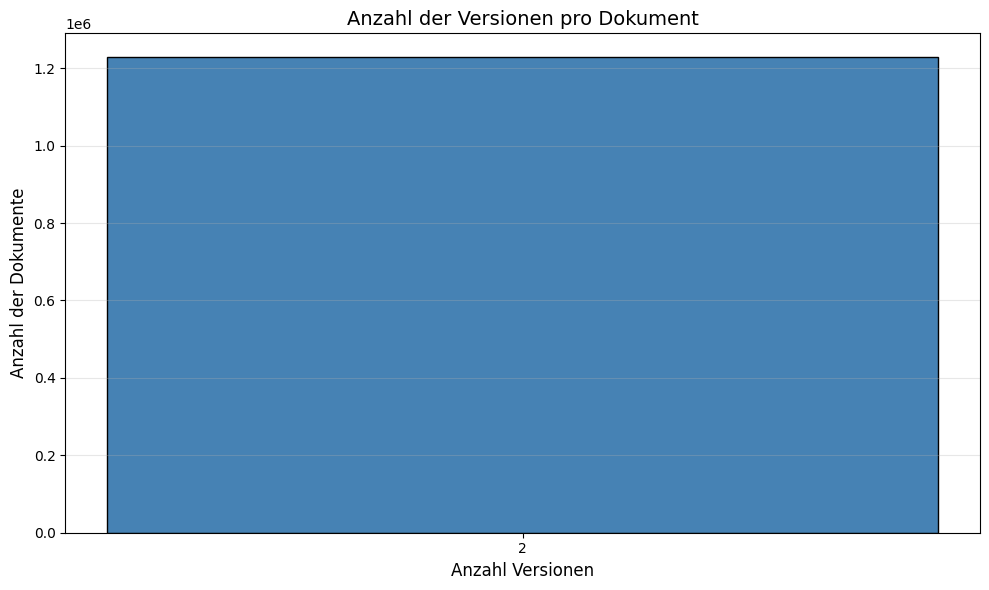

In [5]:
import duckdb
import pandas as pd
import re
import matplotlib.pyplot as plt

# Datenpfad
file_path = "/ds-slt/sci-LLM/scilons/unpaywall_texts_pq/unpaywall_texts_pq_3/eng_Latn/part-*.parquet"

# 1. Basisname der source_zip_content_path extrahieren (ohne den letzten Teil mit der Dateiendung)
query = f"""
    SELECT 
        source_zip_content_path,
        regexp_replace(source_zip_content_path, '\\.(?:grobid|latex)\\.tei\\.xml$', '') AS base_path
    FROM read_parquet('{file_path}')
    WHERE source_zip_content_path IS NOT NULL AND TRIM(source_zip_content_path) != ''
"""
df_paths = duckdb.sql(query).df()

# 2. Zählen, wie oft jeder Basis-Pfad vorkommt
base_path_counts = df_paths['base_path'].value_counts().reset_index()
base_path_counts.columns = ['base_path', 'count']

# 3. Nur die Basispfade behalten, die mehr als einmal vorkommen
duplicate_base_paths = base_path_counts[base_path_counts['count'] > 1]

# 4. Gesamtstatistik
total_docs = len(df_paths)
total_duplicate_base_paths = len(duplicate_base_paths)
total_docs_with_duplicates = duplicate_base_paths['count'].sum()

# 5. Ergebnisse anzeigen
print(f"Gesamtzahl der Dokumente: {total_docs:,}")
print(f"Anzahl der Basis-Pfade mit mehreren Versionen: {total_duplicate_base_paths:,}")
print(f"Anzahl der Dokumente mit alternativen Versionen: {total_docs_with_duplicates:,}")
print(f"Prozent der Dokumente mit mehreren Versionen: {(total_docs_with_duplicates/total_docs)*100:.2f}%")

# 6. Die häufigsten Verteilungen anzeigen (wie oft gibt es 2, 3, 4, ... Versionen vom gleichen Dokument)
version_distribution = duplicate_base_paths['count'].value_counts().sort_index().reset_index()
version_distribution.columns = ['Anzahl Versionen', 'Häufigkeit']
print("\nVerteilung der Anzahl von Versionen pro Dokument:")
display(version_distribution)

# 7. Bei einem Beispiel schauen, welche verschiedenen Versionen es gibt
if total_duplicate_base_paths > 0:
    # Ein Beispiel mit mehreren Versionen nehmen
    sample_base_path = duplicate_base_paths['base_path'].iloc[0]
    sample_files = df_paths[df_paths['base_path'] == sample_base_path]
    
    print(f"\nBeispiel für ein Dokument mit mehreren Versionen:")
    print(f"Basis-Pfad: {sample_base_path}")
    print("Verfügbare Versionen:")
    for path in sample_files['source_zip_content_path']:
        print(f"- {path}")
    
    # Nachsehen, ob diese verschiedenen Versionen unterschiedliche Metadaten haben
    example_query = f"""
        SELECT title, doi, publication_year, source_zip_content_path
        FROM read_parquet('{file_path}')
        WHERE source_zip_content_path IN (
            {','.join([f"'{path}'" for path in sample_files['source_zip_content_path']])}
        )
    """
    df_examples = duckdb.sql(example_query).df()
    print("\nMetadaten der verschiedenen Versionen:")
    display(df_examples)

# 8. Visualisierung der Verteilung
if not version_distribution.empty:
    plt.figure(figsize=(10, 6))
    
    plt.bar(version_distribution['Anzahl Versionen'], version_distribution['Häufigkeit'], 
            color='steelblue', edgecolor='black')
    
    plt.title("Anzahl der Versionen pro Dokument", fontsize=14)
    plt.xlabel("Anzahl Versionen", fontsize=12)
    plt.ylabel("Anzahl der Dokumente", fontsize=12)
    plt.xticks(version_distribution['Anzahl Versionen'])
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

=== Format-Verteilung in Duplikaten ===
Gesamtzahl der Basis-Pfade: 25,560,432

Verteilung der Format-Kombinationen:
grobid: 21,342,055 (83.50%)
other: 2,979,189 (11.66%)
grobid+latex: 1,228,634 (4.81%)
latex: 10,554 (0.04%)

=== Gesamtverteilung der Formate ===
grobid: 22,570,689 (84.25%)
other: 2,979,189 (11.12%)
latex: 1,239,188 (4.63%)


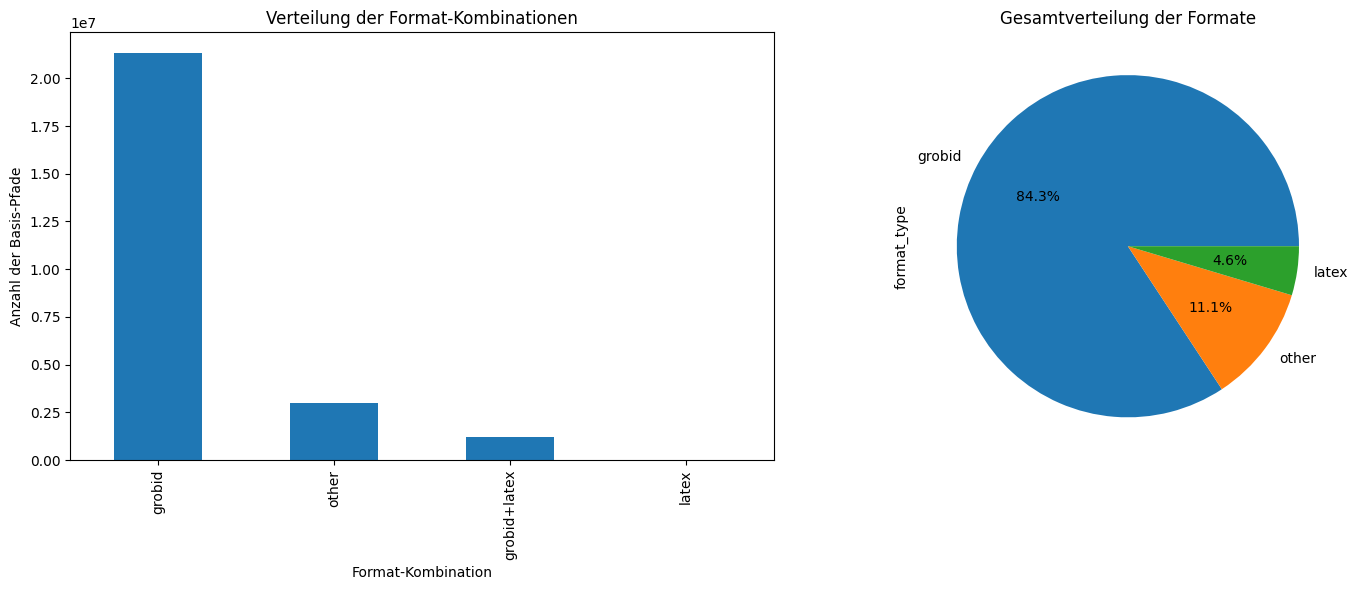


=== Analyse der Duplikate ===
Anzahl der Basis-Pfade mit Duplikaten: 1,228,634

Format-Kombinationen in Duplikaten:
grobid+latex: 1,228,634 (100.00%)

=== Beispiele für verschiedene Format-Kombinationen ===

Kombination: grobid+latex
Basis-Pfad: 00/00/13/1e/0000131e-1ed2-44aa-8158-cfcd351b96fc/0000131e-1ed2-44aa-8158-cfcd351b96fc
- grobid: 00/00/13/1e/0000131e-1ed2-44aa-8158-cfcd351b96fc/0000131e-1ed2-44aa-8158-cfcd351b96fc.grobid.tei.xml
- latex: 00/00/13/1e/0000131e-1ed2-44aa-8158-cfcd351b96fc/0000131e-1ed2-44aa-8158-cfcd351b96fc.latex.tei.xml


In [3]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

# Datenpfad
file_path = "/ds-slt/sci-LLM/scilons/unpaywall_texts_pq/unpaywall_texts_pq_3/eng_Latn/part-*.parquet"

# 1. Basisname und Format extrahieren
query = """
    SELECT 
        source_zip_content_path,
        regexp_replace(source_zip_content_path, '\\.(?:grobid|latex)\\.tei\\.xml$', '') AS base_path,
        CASE 
            WHEN source_zip_content_path LIKE '%.grobid.tei.xml' THEN 'grobid'
            WHEN source_zip_content_path LIKE '%.latex.tei.xml' THEN 'latex'
            ELSE 'other'
        END as format_type
    FROM read_parquet('{file_path}')
    WHERE source_zip_content_path IS NOT NULL AND TRIM(source_zip_content_path) != ''
"""
df_paths = duckdb.sql(query.format(file_path=file_path)).df()

# 2. Gruppieren nach Basis-Pfad und Format
format_analysis = df_paths.groupby('base_path').agg({
    'format_type': lambda x: list(set(x)),
    'source_zip_content_path': 'count'
}).reset_index()

# 3. Analysieren der Format-Kombinationen
format_analysis['format_combination'] = format_analysis['format_type'].apply(lambda x: '+'.join(sorted(x)))
format_distribution = format_analysis['format_combination'].value_counts()

# 4. Statistiken ausgeben
print("=== Format-Verteilung in Duplikaten ===")
print(f"Gesamtzahl der Basis-Pfade: {len(format_analysis):,}")
print("\nVerteilung der Format-Kombinationen:")
for combo, count in format_distribution.items():
    print(f"{combo}: {count:,} ({count/len(format_analysis)*100:.2f}%)")

# 5. Einzelne Format-Zählung
total_formats = df_paths['format_type'].value_counts()
print("\n=== Gesamtverteilung der Formate ===")
for format_type, count in total_formats.items():
    print(f"{format_type}: {count:,} ({count/len(df_paths)*100:.2f}%)")

# 6. Visualisierung
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Format-Kombinationen
format_distribution.plot(kind='bar', ax=ax1)
ax1.set_title('Verteilung der Format-Kombinationen')
ax1.set_xlabel('Format-Kombination')
ax1.set_ylabel('Anzahl der Basis-Pfade')
plt.xticks(rotation=45)

# Plot 2: Gesamtverteilung der Formate
total_formats.plot(kind='pie', autopct='%1.1f%%', ax=ax2)
ax2.set_title('Gesamtverteilung der Formate')

plt.tight_layout()
plt.show()

# 7. Detaillierte Analyse der Duplikate
duplicate_paths = format_analysis[format_analysis['source_zip_content_path'] > 1]
print("\n=== Analyse der Duplikate ===")
print(f"Anzahl der Basis-Pfade mit Duplikaten: {len(duplicate_paths):,}")

duplicate_format_dist = duplicate_paths['format_combination'].value_counts()
print("\nFormat-Kombinationen in Duplikaten:")
for combo, count in duplicate_format_dist.items():
    print(f"{combo}: {count:,} ({count/len(duplicate_paths)*100:.2f}%)")

# 8. Beispiele für verschiedene Kombinationen
print("\n=== Beispiele für verschiedene Format-Kombinationen ===")
for combo in duplicate_format_dist.index[:3]:  # Top 3 Kombinationen
    sample = duplicate_paths[duplicate_paths['format_combination'] == combo].iloc[0]
    print(f"\nKombination: {combo}")
    print(f"Basis-Pfad: {sample['base_path']}")
    matching_files = df_paths[df_paths['base_path'] == sample['base_path']]
    for _, file in matching_files.iterrows():
        print(f"- {file['format_type']}: {file['source_zip_content_path']}")

In [2]:
import duckdb

# Datenpfad
file_path = "/ds-slt/sci-LLM/scilons/unpaywall_texts_pq/unpaywall_texts_pq_3/eng_Latn/part-*.parquet"

# Simple Abfrage für 'other' Formate
query = """
    SELECT source_zip_content_path
    FROM read_parquet('{file_path}')
    WHERE source_zip_content_path NOT LIKE '%.grobid.tei.xml'
        AND source_zip_content_path NOT LIKE '%.latex.tei.xml'
        AND source_zip_content_path IS NOT NULL 
        AND TRIM(source_zip_content_path) != ''
    LIMIT 100
"""

# Ausführen und Ausgeben
print("=== 5 Beispiele für 'other' Formate ===")
other_examples = duckdb.sql(query.format(file_path=file_path)).df()
for path in other_examples['source_zip_content_path']:
    print(f"- {path}")

=== 5 Beispiele für 'other' Formate ===
- 63/a7/11/42/63a71142-0508-4a91-9739-fe73425a5ad4/63a71142-0508-4a91-9739-fe73425a5ad4.pub2tei.tei.xml
- ad/62/b2/ce/ad62b2ce-7365-4636-be0e-8a7ed173a5dd/ad62b2ce-7365-4636-be0e-8a7ed173a5dd.pub2tei.tei.xml
- 34/34/00/c5/343400c5-ea6c-4198-87e8-73cd78b9faec/343400c5-ea6c-4198-87e8-73cd78b9faec.pub2tei.tei.xml
- 75/b9/b7/47/75b9b747-a878-4028-a837-398ec971296d/75b9b747-a878-4028-a837-398ec971296d.pub2tei.tei.xml
- 34/7c/ff/fa/347cfffa-465a-4198-83e4-98318d5179ea/347cfffa-465a-4198-83e4-98318d5179ea.pub2tei.tei.xml
- 34/d2/7d/71/34d27d71-052e-4084-a0bd-91264e2c55cd/34d27d71-052e-4084-a0bd-91264e2c55cd.pub2tei.tei.xml
- 34/7e/ef/03/347eef03-3948-4331-9e62-62176d0df7ba/347eef03-3948-4331-9e62-62176d0df7ba.pub2tei.tei.xml
- 75/69/be/2f/7569be2f-0f86-43eb-b76f-55c1e774b639/7569be2f-0f86-43eb-b76f-55c1e774b639.pub2tei.tei.xml
- 75/f2/50/50/75f25050-1be9-4d33-98e0-42f1ce516785/75f25050-1be9-4d33-98e0-42f1ce516785.pub2tei.tei.xml
- 75/d4/cb/1b/75d4cb1b-d


---

# Hash Dataset

```
=== Processing Summary ===
Total processing time: 51m 59s
Average time per file: 1m 59s
Total input records: 26,789,066
Total output records: 26,789,066
2025-04-02 19:03:15,650 - INFO -
Processing completed!
2025-04-02 19:03:15,650 - INFO - Total processing time: 51m 59s
2025-04-02 19:03:15,651 - INFO - Total input records: 26,789,066
2025-04-02 19:03:15,651 - INFO - Total output records: 26,789,066

Processed files saved in: /netscratch/nrauscher/projects/BA-NikolasRauscher/data/processed
2025-04-02 19:03:15,652 - INFO - Processed files saved in: /netscratch/nrauscher/projects/BA-NikolasRauscher/data/processed

```

In [2]:
ls /netscratch/nrauscher/projects/BA-NikolasRauscher/data/processed/

processed_part-0.parquet   processed_part-17.parquet  processed_part-25.parquet
processed_part-1.parquet   processed_part-18.parquet  processed_part-3.parquet
processed_part-10.parquet  processed_part-19.parquet  processed_part-4.parquet
processed_part-11.parquet  processed_part-2.parquet   processed_part-5.parquet
processed_part-12.parquet  processed_part-20.parquet  processed_part-6.parquet
processed_part-13.parquet  processed_part-21.parquet  processed_part-7.parquet
processed_part-14.parquet  processed_part-22.parquet  processed_part-8.parquet
processed_part-15.parquet  processed_part-23.parquet  processed_part-9.parquet
processed_part-16.parquet  processed_part-24.parquet


In [2]:
# The new Dataset is now under /netscratch/nrauscher/projects/BA-NikolasRauscher/data/processed

# Print head of the new dataset and first 10 rows

import duckdb

file_path = "/netscratch/nrauscher/projects/BA-NikolasRauscher/data/processed/processed_part-*.parquet"

# Schema ermitteln
df_schema = duckdb.sql(f"""
    DESCRIBE SELECT * 
    FROM read_parquet('{file_path}')
""").df()

df_schema


,column_name,column_type,null,key,default,extra
0,content_hash,VARCHAR,YES,None,None,None
1,text,VARCHAR,YES,None,None,None
2,language_score,VARCHAR,YES,None,None,None
3,source_file_path,VARCHAR,YES,None,None,None
4,source_zip_content_path,VARCHAR,YES,None,None,None
5,doi,VARCHAR,YES,None,None,None
6,authors,VARCHAR,YES,None,None,None
7,title,VARCHAR,YES,None,None,None
8,pdf_md5_hash,VARCHAR,YES,None,None,None
9,publisher,VARCHAR,YES,None,None,None


In [10]:
base_path = "/netscratch/nrauscher/projects/BA-NikolasRauscher/data/processed/processed_part-*.parquet"

sample_size = 5
# Query anpassen, um alle Spalten für 5 Beispieleinträge zu zeigen
query = f"""
SELECT *
FROM read_parquet('{base_path}')
WHERE title IS NOT NULL AND LENGTH(title) > 10
LIMIT 5;
"""

# Query ausführen und vollständige Beispiele anzeigen
print("5 Beispieleinträge aus dem Dataset:")
example_entries = duckdb.sql(query).df()
display(example_entries)

# Dann die ursprüngliche Sample-Query für die weitere Verarbeitung mit allen Spalten
sample_query = f"""
WITH all_data AS (
    SELECT *, ROW_NUMBER() OVER (ORDER BY RANDOM()) as rn
    FROM read_parquet('{base_path}')
    WHERE title IS NOT NULL AND LENGTH(title) > 10
)
SELECT * EXCEPT(rn)
FROM all_data
WHERE rn <= {sample_size}
"""

# Query ausführen und DataFrame erstellen
df = duckdb.sql(sample_query).df()
print(f"\nAnzahl der gesammelten Einträge: {len(df)}")
display(df)

5 Beispieleinträge aus dem Dataset:


,content_hash,text,language_score,source_file_path,source_zip_content_path,doi,authors,title,pdf_md5_hash,publisher,journal,journal_abbrev,publication_year
0,4720ec5ebfa9ec55ed3d90052f292b2c,Neotectonic crustal extension in SW Bulgaria\n...,0.7584828910456287,unpaywall/0096/tei.zip,75/37/1f/51/75371f51-b4fb-44f9-bae2-373fd9377c...,,,Neotectonic crustal extension in SW Bulgaria,89EA9696669FEB1C4A10F6B54E3891F0,,,,0
1,3833021e866d6bd1e4e4a627ebfa7ab6,Parity anomaly and Landau-level lasing in stra...,0.8842030232447939,unpaywall/0064/tei.zip,ad/98/8c/7b/ad988c7b-c3e7-44b9-8f63-7291616a16...,,"Schomerus Henning, Halpern Nicole Yunger",Parity anomaly and Landau-level lasing in stra...,,,,,2023
2,15ca8adfc5a75770c1b336ca79a0eb65,On Unemployment Inflow and Outflow in Urban Ch...,0.9324237873406978,unpaywall/0096/tei.zip,75/d0/fe/68/75d0fe68-6880-4c16-9712-75fecf94c0...,10.1080/00343400600660748,"Zhongmin Wu, Shujie Yao",On Unemployment Inflow and Outflow in Urban China,2A4CDD09ED60B23562EB4EA37E5CF705,Informa UK Limited,,,2006
3,d69217d501d2b98b4494cda0a9ec3855,Long-term results of aggressive hemiarch repla...,0.8304926479463831,unpaywall/0032/tei.zip,75/e3/4c/36/75e34c36-aa99-4b68-b650-f904bcf7a1...,10.1016/j.jtcvs.2014.05.093,"MD Bartosz Rylski, MD Rita K Milewski, MD Jose...",Long-term results of aggressive hemiarch repla...,090C0FDF1BD39BD908A4EC55AF35D067,Elsevier BV,,,2014
4,fb699e1ce12a10089a4f41baa62f4b6e,Parity anomaly and Landau-level lasing in stra...,0.8826354023585553,unpaywall/0064/tei.zip,ad/98/8c/7b/ad988c7b-c3e7-44b9-8f63-7291616a16...,,"Henning Schomerus, Nicole Yunger Halpern",Parity anomaly and Landau-level lasing in stra...,A3297D61851DFE3F720BBF4F3EB6D20B,,,,2013


ParserException: Parser Error: syntax error at or near "rn"